In [2]:
import os
import random
import gc

import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import cv2
from imutils import paths
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
os.sys.path.append('../src')
from helpers import resize_to_fit

In [4]:
data_dir = os.path.abspath(os.path.relpath('../data'))
image_dir = os.path.abspath(os.path.relpath('../doc/images'))

In [35]:
CAPTCHA_IMAGES_FOLDER = "../data/samples"

# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(CAPTCHA_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Add a third channel dimension to the image
    image = np.expand_dims(image, axis=2)

    # Grab the labels
    label = image_file.split(os.path.sep)[-1].split('.')[-2]

    # Add the image and it's label to our training data
    data.append(image)
    labels.append(label)

In [36]:
data_t = (torch.from_numpy(np.array(data)).float().transpose(1,3)).transpose(2,3)

In [57]:
data_t.shape

torch.Size([1070, 1, 50, 200])

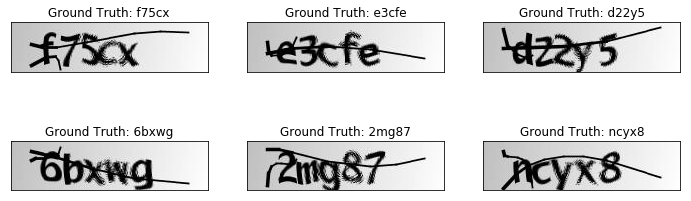

In [42]:
fig = plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(2,3,i+1)
#    plt.tight_layout()
    plt.imshow(data_t[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(labels[i]))
    plt.xticks([])
    plt.yticks([])

## K-Means

In [62]:
data_ = (np.array(data, dtype="float") / 255.0)[:,:,:,0]
data_.shape

(1070, 50, 200)

In [65]:
data_ = data_t.view(-1, 10000)

In [54]:
from sklearn.cluster import KMeans

In [66]:
km = KMeans(5)
km.fit(data_)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

## Convolutional Neural Network

In [31]:
mnist_trainset = datasets.MNIST(root='../data', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]))

mnist_testset = datasets.MNIST(root='../data', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]))

In [32]:
LETTER_IMAGES_FOLDER = "../data/extracted_letter_images"

# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 28x28 pixel box
    image = resize_to_fit(image, 28, 28)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]

    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)


In [33]:
# scale the raw pixel intensities to the range [0, 1] (this improves training)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [34]:
# Split the training data into separate train and test sets
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

# Convert the labels (letters) into one-hot encodings that Keras can work with
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [36]:
batch_size_train = X_train.shape[0]/1000
batch_size_test = 1000
learning_rate = 0.01
n_epochs = 1
log_interval = 10

In [37]:
X_train_t = (torch.from_numpy(X_train).float().transpose(1,3)).transpose(2,3)
y_train_t = torch.from_numpy(y_train).long()

train_data = torch.utils.data.TensorDataset(X_train_t, y_train_t)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True)

ValueError: batch_size should be a positive integeral value, but got batch_size=29.058

In [ ]:
X_test_t = (torch.from_numpy(X_test).float().transpose(1,3)).transpose(2,3)
y_test_t = torch.from_numpy(y_test).long()

test_data = torch.utils.data.TensorDataset(X_test_t, y_test_t)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(le.inverse_transform(example_targets)[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 32)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=0)

In [19]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [20]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [44]:
def train(epoch, v=True):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target, reduction='mean')
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            if v:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        torch.save(net.state_dict(), 'model.pth')
        torch.save(optimizer.state_dict(), 'optimizer.pth')

In [22]:
def test():
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = net(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [23]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 6.8826, Accuracy: 189/9686 (1%)

Train Epoch: 1 [0/29058 (0%)]	Loss: 4.164946
Train Epoch: 1 [640/29058 (2%)]	Loss: 4.074104
Train Epoch: 1 [1280/29058 (4%)]	Loss: 3.390625
Train Epoch: 1 [1920/29058 (7%)]	Loss: 3.014214
Train Epoch: 1 [2560/29058 (9%)]	Loss: 2.646719
Train Epoch: 1 [3200/29058 (11%)]	Loss: 2.639846
Train Epoch: 1 [3840/29058 (13%)]	Loss: 2.403388
Train Epoch: 1 [4480/29058 (15%)]	Loss: 2.334451
Train Epoch: 1 [5120/29058 (18%)]	Loss: 2.163084
Train Epoch: 1 [5760/29058 (20%)]	Loss: 2.106150
Train Epoch: 1 [6400/29058 (22%)]	Loss: 2.129594
Train Epoch: 1 [7040/29058 (24%)]	Loss: 1.783511
Train Epoch: 1 [7680/29058 (26%)]	Loss: 2.013033
Train Epoch: 1 [8320/29058 (29%)]	Loss: 1.920113
Train Epoch: 1 [8960/29058 (31%)]	Loss: 1.697120
Train Epoch: 1 [9600/29058 (33%)]	Loss: 1.947320
Train Epoch: 1 [10240/29058 (35%)]	Loss: 1.806337
Train Epoch: 1 [10880/29058 (37%)]	Loss: 1.631441
Train Epoch: 1 [11520/29058 (40%)]	Loss: 1.653622
Train Epoch: 1 [1216

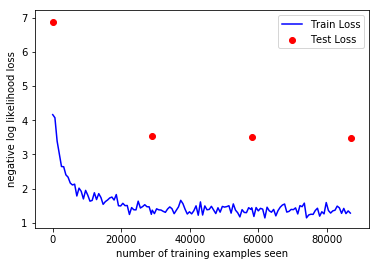

In [24]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

In [25]:
with torch.no_grad():
    output = net(example_data)

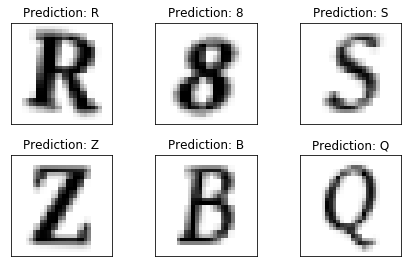

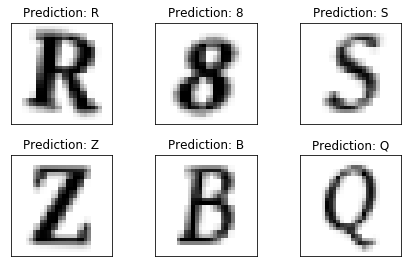

In [26]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(le.inverse_transform(output.data.max(1, keepdim=True)[1][i])[0]))
    plt.xticks([])
    plt.yticks([])

In [41]:
class Net(nn.Module):
    def __init__(self, H, D):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 32)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=0)


Net with H = 50, D = 0

Test set: Avg. loss: 6.8807, Accuracy: 250/9686 (2%)


Test set: Avg. loss: 3.5304, Accuracy: 9603/9686 (99%)


Test set: Avg. loss: 3.4932, Accuracy: 9617/9686 (99%)


Test set: Avg. loss: 3.5136, Accuracy: 9625/9686 (99%)


Test set: Avg. loss: 3.5011, Accuracy: 9627/9686 (99%)


Test set: Avg. loss: 3.4904, Accuracy: 9631/9686 (99%)



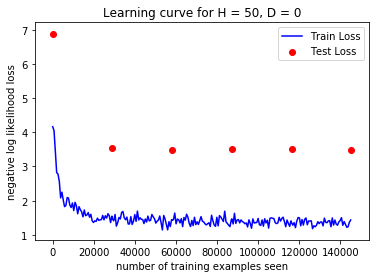


Net with H = 50, D = 0.3

Test set: Avg. loss: 6.8809, Accuracy: 273/9686 (2%)


Test set: Avg. loss: 3.5965, Accuracy: 9537/9686 (98%)


Test set: Avg. loss: 3.5456, Accuracy: 9557/9686 (98%)


Test set: Avg. loss: 3.5332, Accuracy: 9583/9686 (98%)


Test set: Avg. loss: 3.5278, Accuracy: 9603/9686 (99%)


Test set: Avg. loss: 3.5063, Accuracy: 9604/9686 (99%)



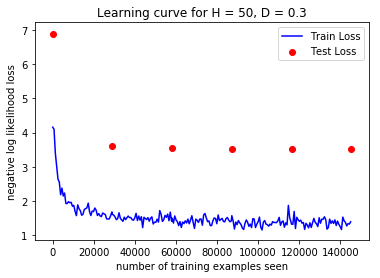


Net with H = 50, D = 0.5

Test set: Avg. loss: 6.8805, Accuracy: 217/9686 (2%)


Test set: Avg. loss: 3.5307, Accuracy: 9612/9686 (99%)


Test set: Avg. loss: 3.4909, Accuracy: 9619/9686 (99%)


Test set: Avg. loss: 3.4870, Accuracy: 9628/9686 (99%)


Test set: Avg. loss: 3.4837, Accuracy: 9635/9686 (99%)


Test set: Avg. loss: 3.4979, Accuracy: 9643/9686 (99%)



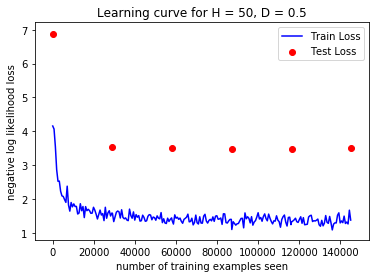


Net with H = 50, D = 0.7

Test set: Avg. loss: 6.8816, Accuracy: 243/9686 (2%)


Test set: Avg. loss: 3.5219, Accuracy: 9610/9686 (99%)


Test set: Avg. loss: 3.4993, Accuracy: 9625/9686 (99%)


Test set: Avg. loss: 3.4822, Accuracy: 9643/9686 (99%)


Test set: Avg. loss: 3.4754, Accuracy: 9641/9686 (99%)


Test set: Avg. loss: 3.4746, Accuracy: 9633/9686 (99%)



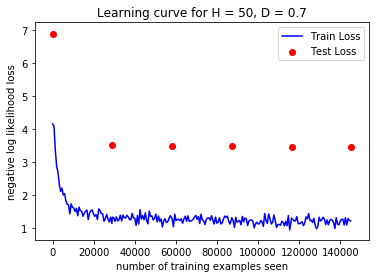


Net with H = 120, D = 0

Test set: Avg. loss: 6.8815, Accuracy: 282/9686 (2%)


Test set: Avg. loss: 3.6564, Accuracy: 9455/9686 (97%)


Test set: Avg. loss: 3.5767, Accuracy: 9548/9686 (98%)


Test set: Avg. loss: 3.6035, Accuracy: 9549/9686 (98%)


Test set: Avg. loss: 3.5538, Accuracy: 9576/9686 (98%)


Test set: Avg. loss: 3.5321, Accuracy: 9567/9686 (98%)



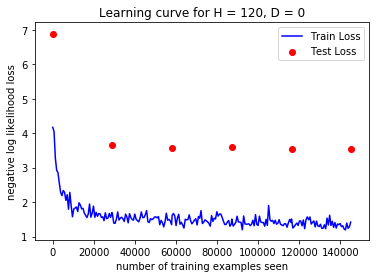


Net with H = 120, D = 0.3

Test set: Avg. loss: 6.8815, Accuracy: 163/9686 (1%)


Test set: Avg. loss: 3.5122, Accuracy: 9597/9686 (99%)


Test set: Avg. loss: 3.4895, Accuracy: 9624/9686 (99%)


Test set: Avg. loss: 3.4986, Accuracy: 9629/9686 (99%)


Test set: Avg. loss: 3.4882, Accuracy: 9633/9686 (99%)


Test set: Avg. loss: 3.4974, Accuracy: 9633/9686 (99%)



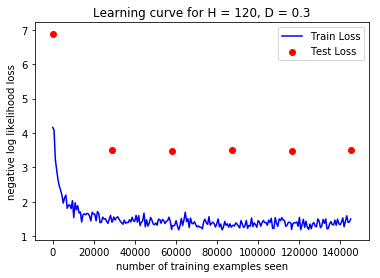


Net with H = 120, D = 0.5

Test set: Avg. loss: 6.8831, Accuracy: 170/9686 (1%)


Test set: Avg. loss: 3.5173, Accuracy: 9609/9686 (99%)


Test set: Avg. loss: 3.5087, Accuracy: 9627/9686 (99%)


Test set: Avg. loss: 3.5048, Accuracy: 9625/9686 (99%)


Test set: Avg. loss: 3.5019, Accuracy: 9626/9686 (99%)


Test set: Avg. loss: 3.5581, Accuracy: 9569/9686 (98%)



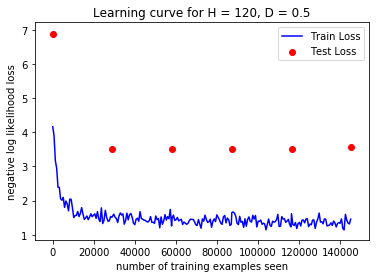


Net with H = 120, D = 0.7

Test set: Avg. loss: 6.8810, Accuracy: 200/9686 (2%)


Test set: Avg. loss: 3.5120, Accuracy: 9623/9686 (99%)


Test set: Avg. loss: 3.4747, Accuracy: 9634/9686 (99%)


Test set: Avg. loss: 3.4700, Accuracy: 9634/9686 (99%)


Test set: Avg. loss: 3.4719, Accuracy: 9639/9686 (99%)


Test set: Avg. loss: 3.4955, Accuracy: 9635/9686 (99%)



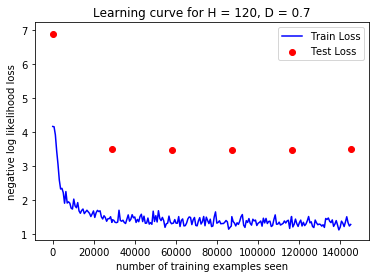


Net with H = 320, D = 0

Test set: Avg. loss: 6.8818, Accuracy: 211/9686 (2%)


Test set: Avg. loss: 3.4981, Accuracy: 9628/9686 (99%)


Test set: Avg. loss: 3.4785, Accuracy: 9647/9686 (99%)


Test set: Avg. loss: 3.4840, Accuracy: 9639/9686 (99%)


Test set: Avg. loss: 3.4741, Accuracy: 9649/9686 (99%)


Test set: Avg. loss: 3.4825, Accuracy: 9632/9686 (99%)



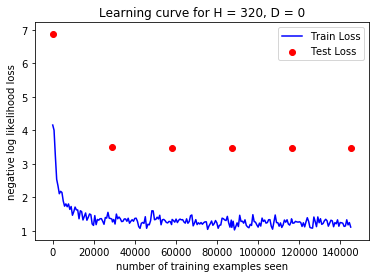


Net with H = 320, D = 0.3

Test set: Avg. loss: 6.8806, Accuracy: 313/9686 (3%)


Test set: Avg. loss: 3.5065, Accuracy: 9608/9686 (99%)


Test set: Avg. loss: 3.5039, Accuracy: 9619/9686 (99%)


Test set: Avg. loss: 3.5020, Accuracy: 9620/9686 (99%)


Test set: Avg. loss: 3.4836, Accuracy: 9632/9686 (99%)


Test set: Avg. loss: 3.5103, Accuracy: 9635/9686 (99%)



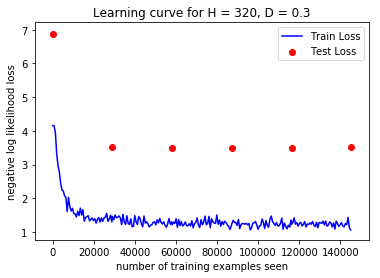


Net with H = 320, D = 0.5

Test set: Avg. loss: 6.8814, Accuracy: 239/9686 (2%)


Test set: Avg. loss: 3.5349, Accuracy: 9595/9686 (99%)


Test set: Avg. loss: 3.5066, Accuracy: 9597/9686 (99%)


Test set: Avg. loss: 3.5035, Accuracy: 9619/9686 (99%)


Test set: Avg. loss: 3.9547, Accuracy: 9161/9686 (94%)


Test set: Avg. loss: 3.4902, Accuracy: 9627/9686 (99%)



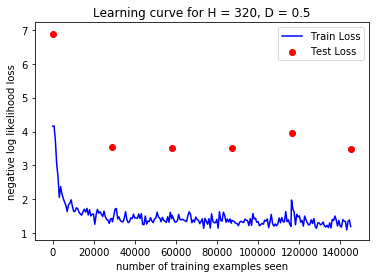


Net with H = 320, D = 0.7

Test set: Avg. loss: 6.8808, Accuracy: 519/9686 (5%)


Test set: Avg. loss: 3.5877, Accuracy: 9530/9686 (98%)


Test set: Avg. loss: 3.5842, Accuracy: 9542/9686 (98%)


Test set: Avg. loss: 3.5143, Accuracy: 9581/9686 (98%)


Test set: Avg. loss: 3.5131, Accuracy: 9582/9686 (98%)


Test set: Avg. loss: 3.5079, Accuracy: 9595/9686 (99%)



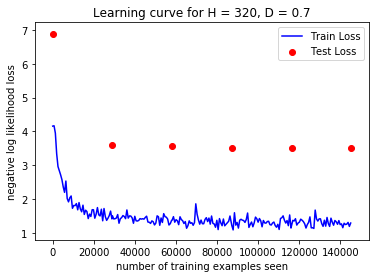

In [46]:
n_epochs = 5

for H in [50, 120, 320]:
    for D in [0, 0.3, 0.5, 0.7]:
        net = Net(H, D)
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)
        
        train_losses = []
        train_counter = []
        test_losses = []
        test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
        
        print("\nNet with H = {}, D = {}".format(H, D))
        
        test()
        for epoch in range(1, n_epochs + 1):
            train(epoch, False)
            test()
            
        fig = plt.figure()
        plt.plot(train_counter, train_losses, color='blue')
        plt.scatter(test_counter, test_losses, color='red')
        plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
        plt.xlabel('number of training examples seen')
        plt.ylabel('negative log likelihood loss')
        plt.title('Learning curve for H = {}, D = {}'.format(H, D))
        plt.show()   